In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time                   # To time processes
import warnings               # To suppress warnings
import itertools
import datetime

from random import shuffle
from pandas import read_csv
from sklearn import metrics
from sklearn import svm
from matplotlib import pyplot
from numpy import array
from numpy import argmax

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from matplotlib.pyplot import *

In [58]:
dataset = read_csv("../Dataset/big_student_clear_third_version.csv", encoding="ISO-8859-1")
#forum=read_csv("../Dataset/course_posts.csv")

In [59]:
df=dataset[['viewed','explored','certified','gender', 'grade', 'nevents', 'ndays_act', 'nchapters', 'nplay_video' ,'semester', 'LoE_DI','nforum_posts']]
df_start=dataset[['start_time_DI']]
df_end=dataset[['last_event_DI']]

In [60]:
dataset.shape[0]
warnings.filterwarnings("ignore")

In [61]:
# for normalizing grades and gender missing values

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


df[['grade']] = DataFrameImputer().fit_transform(df[['grade']])
df[['gender']]= DataFrameImputer().fit_transform(df[['gender']])

In [62]:
#One-hot encoding for converting gender m/f to 0/1
data = df[['gender']]
values = array(data)
#print(values)
values.ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
df[['gender']]=integer_encoded

In [63]:
#One-hot encoding for converting Level of Education
data = df[['LoE_DI']]
values = array(data)
#print(values)
values.ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
df[['LoE_DI']]=integer_encoded

In [64]:
#One-hot encoding for converting semester
data = df[['semester']]
values = array(data)
#print(values)
values.ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
df[['semester']]=integer_encoded

In [65]:
#Converting Start date into unix timestamp
df_start = df_start.applymap(str)
start_temp= np.zeros(shape=(df_start.shape[0],1))
for ix in df_start.index:
    start_temp[ix]=int(time.mktime(datetime.datetime.strptime(df_start.loc[ix]['start_time_DI'], "%Y-%m-%d").timetuple()))

df_temp1=pd.DataFrame({'Start date':start_temp[:,0]})
df_temp1.head()

df=pd.concat([df,df_temp1], axis=1)

In [66]:
#Converting Last event date into unix timestamp
df_end = df_end.applymap(str)
end_temp= np.zeros(shape=(df_end.shape[0],1))
for ix in df_end.index:
    end_temp[ix]=int(time.mktime(datetime.datetime.strptime(df_end.loc[ix]['last_event_DI'], "%Y-%m-%d").timetuple()))

df_temp2=pd.DataFrame({'Last event date':end_temp[:,0]})
df_temp2.head()

df=pd.concat([df,df_temp2], axis=1)

In [67]:
df.isnull().sum()

viewed             0
explored           0
certified          0
gender             0
grade              0
nevents            0
ndays_act          0
nchapters          0
nplay_video        0
semester           0
LoE_DI             0
nforum_posts       0
Start date         0
Last event date    0
dtype: int64

In [68]:
df.head()

,viewed,explored,certified,gender,grade,nevents,ndays_act,nchapters,nplay_video,semester,LoE_DI,nforum_posts,Start date,Last event date
0,0,0,0,1,0.0,6,3,0,197757,0,0,0,1.343068e+09,1.374863e+09
1,1,0,0,1,0.0,107,8,2,7,0,4,0,1.343068e+09,1.356287e+09
2,1,0,0,1,0.0,8,1,1,197757,2,0,0,1.343068e+09,1.364409e+09
3,1,0,0,1,0.0,25,2,4,197757,2,4,0,1.343068e+09,1.373827e+09
4,0,0,0,0,0.0,3,2,0,197757,0,3,0,1.343068e+09,1.345833e+09


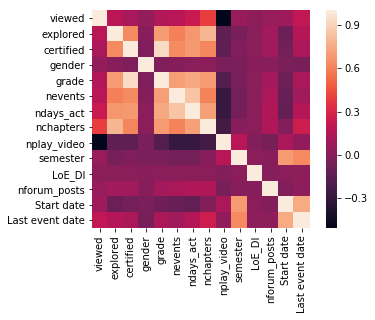

In [69]:
cor = df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [70]:
# Clustering for completed or not for all weeks dataset
j=0
week11=df[['viewed','explored','certified','gender', 'grade', 'nevents', 'ndays_act', 'nchapters']]
week11=week11.values
kmeans = KMeans(n_clusters=2)
kmeans.fit(week11)
y_km = kmeans.fit_predict(week11)
df7= pd.DataFrame({'Completed_or_not':y_km})
#df7=df7.values
print(np.array(np.unique(y_km, return_counts=True)).T)
df=pd.concat([df,df7],axis=1)

[[     0 404741]
 [     1  12180]]


In [71]:
df.head()

,viewed,explored,certified,gender,grade,nevents,ndays_act,nchapters,nplay_video,semester,LoE_DI,nforum_posts,Start date,Last event date,Completed_or_not
0,0,0,0,1,0.0,6,3,0,197757,0,0,0,1.343068e+09,1.374863e+09,0
1,1,0,0,1,0.0,107,8,2,7,0,4,0,1.343068e+09,1.356287e+09,0
2,1,0,0,1,0.0,8,1,1,197757,2,0,0,1.343068e+09,1.364409e+09,0
3,1,0,0,1,0.0,25,2,4,197757,2,4,0,1.343068e+09,1.373827e+09,0
4,0,0,0,0,0.0,3,2,0,197757,0,3,0,1.343068e+09,1.345833e+09,0


In [72]:
df77=read_csv('Testing dataset.csv')
df88=read_csv('Testing result.csv')
print(df77.shape[0])
print(df88.shape[0])

59278
59278


In [73]:
df_minority = df[df['Completed_or_not']==1]
df_majority = df[df['Completed_or_not']==0]

In [74]:
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=15576,    # to match majority class
                                 random_state=123) # reproducible results

In [75]:
df = pd.concat([df_majority, df_minority_upsampled])

In [76]:
df.shape[0]

420317

In [77]:
df['Completed_or_not'].value_counts()

0    404741
1     15576
Name: Completed_or_not, dtype: int64

In [78]:
df=df.iloc[np.random.permutation(np.arange(len(df)))]

In [79]:
week1=df[0:84064]
week2=df[84064:168128]
week3=df[168128:252192]
week4=df[252192:336256]
week5=df[336256:420320]

In [80]:
week1.shape[0]

84064

In [81]:
week5['Completed_or_not'].value_counts()

0    80899
1     3162
Name: Completed_or_not, dtype: int64

In [82]:
week1=week1.drop(['gender','nplay_video','semester','nforum_posts','Start date'], axis=1)

In [83]:
l=[]
for i in range (0,5):
    j=0
    while(j<300):
        x=random.randint(0,59278)
        #print(x)
        if(l.count(x)<=0):
            l.append(x)
            j=j+1
            dftemp=df77.loc[x,['viewed','explored','grade','nevents','ndays_act','nchapters','LoE_DI','last_event_DI','certified']]
            #print(dftemp)
            dftemp=pd.concat([dftemp,df88.loc[x,['Completed_or_not']]],axis=0)
            #print(type(dftemp))
            dftemp = dftemp.to_frame().reset_index()
            dftemp=dftemp.T
            #print(type(dftemp))
            #print(dftemp.shape)
            dftemp.columns=['viewed','explored','grade','nevents','ndays_act','nchapters','LoE_DI','Last event date','certified','Completed_or_not']
            dftemp=dftemp.drop(index='index')
            if(i==0):
                dftemp.rename(index={x:week1.shape[0]},inplace=True)
                week1=pd.concat([week1,dftemp])
                dftemp.iloc[0:0]
            elif(i==1):
                dftemp.rename(index={x:week2.shape[0]},inplace=True)
                week2=pd.concat([week2,dftemp])
                dftemp.iloc[0:0]
            elif(i==2):
                dftemp.rename(index={x:week3.shape[0]},inplace=True)
                week3=pd.concat([week3,dftemp])
                dftemp.iloc[0:0]
            elif(i==3):
                dftemp.rename(index={x:week4.shape[0]},inplace=True)
                week4=pd.concat([week4,dftemp])
                dftemp.iloc[0:0]
            elif(i==4):
                dftemp.rename(index={x:week5.shape[0]},inplace=True)
                week5=pd.concat([week5,dftemp])
                dftemp.iloc[0:0]

In [84]:
week5['Completed_or_not'].value_counts()

0    81196
1     3165
Name: Completed_or_not, dtype: int64

In [85]:
week1.to_csv('Week 1.csv')
week2.to_csv('Week 2.csv')
week3.to_csv('Week 3.csv')
week4.to_csv('Week 4.csv')
week5.to_csv('Week 5.csv')